# Imports

we try to use numerous models of CVs and then combine them using to get the best performances

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import random_split

import torch
import torchvision.transforms.functional as FTV
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18
import torch.nn as nn
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


import utils.helpers as h
import utils.custom_labeled_dataset as cl
import utils.custom_dataset as c

### Images pre-processing & Loading (Train images)

In [2]:
# Dict defining rotation and cropping depending on component (selon les prises de vue)
rot_crop_data = {
        "Die01":[55,(340, 120, 500, 680)], # (left, upper, right, lower)
        "Die02":[-44, (480, 210, 640, 930)],
        "Die03":[134, (460, 200, 620, 920)],
        "Die04":[35, (310, 130, 470, 690)]
}

In [3]:
# train_pictures = 'input_train\input_train'
# train_labels = 'Y_train_eVW9jym.csv'

# # Pre-process test data
# train_df = pd.read_csv(train_labels)

In [4]:
# # to be excuted only once
# for index, row in train_df.iterrows():
#     path = os.path.join(train_pictures, row['filename'])
#     h.rotate_and_crop_image(path, rot_crop_data[row['lib']][0], rot_crop_data[row['lib']][1], plot=False)

# Quick Data Exploration

In [5]:
map_label_idx = {
    "GOOD": 0,
    "Boucle plate": 1,
    "Lift-off blanc": 2,
    "Lift-off noir": 3,
    "Missing": 4,
    "Short circuit MOS": 5
}
map_idx_label = {
    0: "GOOD",
    1: "Boucle plate",
    2: "Lift-off blanc",
    3: "Lift-off noir",
    4: "Missing",
    5: "Short circuit MOS"
}

In [6]:
transform = transforms.Compose([
                                transforms.Resize((256, 256)),  # Redimensionner les images
                                transforms.ToTensor(),            # Convertir en tenseur
                                ])
labeled_pictures = 'data\input_train'
true_labels = 'data\Y_train_eVW9jym.csv'

labeled_dataset = cl.CustomImageDataset(true_labels, labeled_pictures, map_label_idx, transform=transform)
dataset_loader = DataLoader(labeled_dataset, batch_size=256, shuffle=True)

In [7]:
print(f"Dataset contains {len(labeled_dataset)} images.")

image, label = labeled_dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")

Dataset contains 8278 images.
Image shape: torch.Size([3, 256, 256]), Label: 4


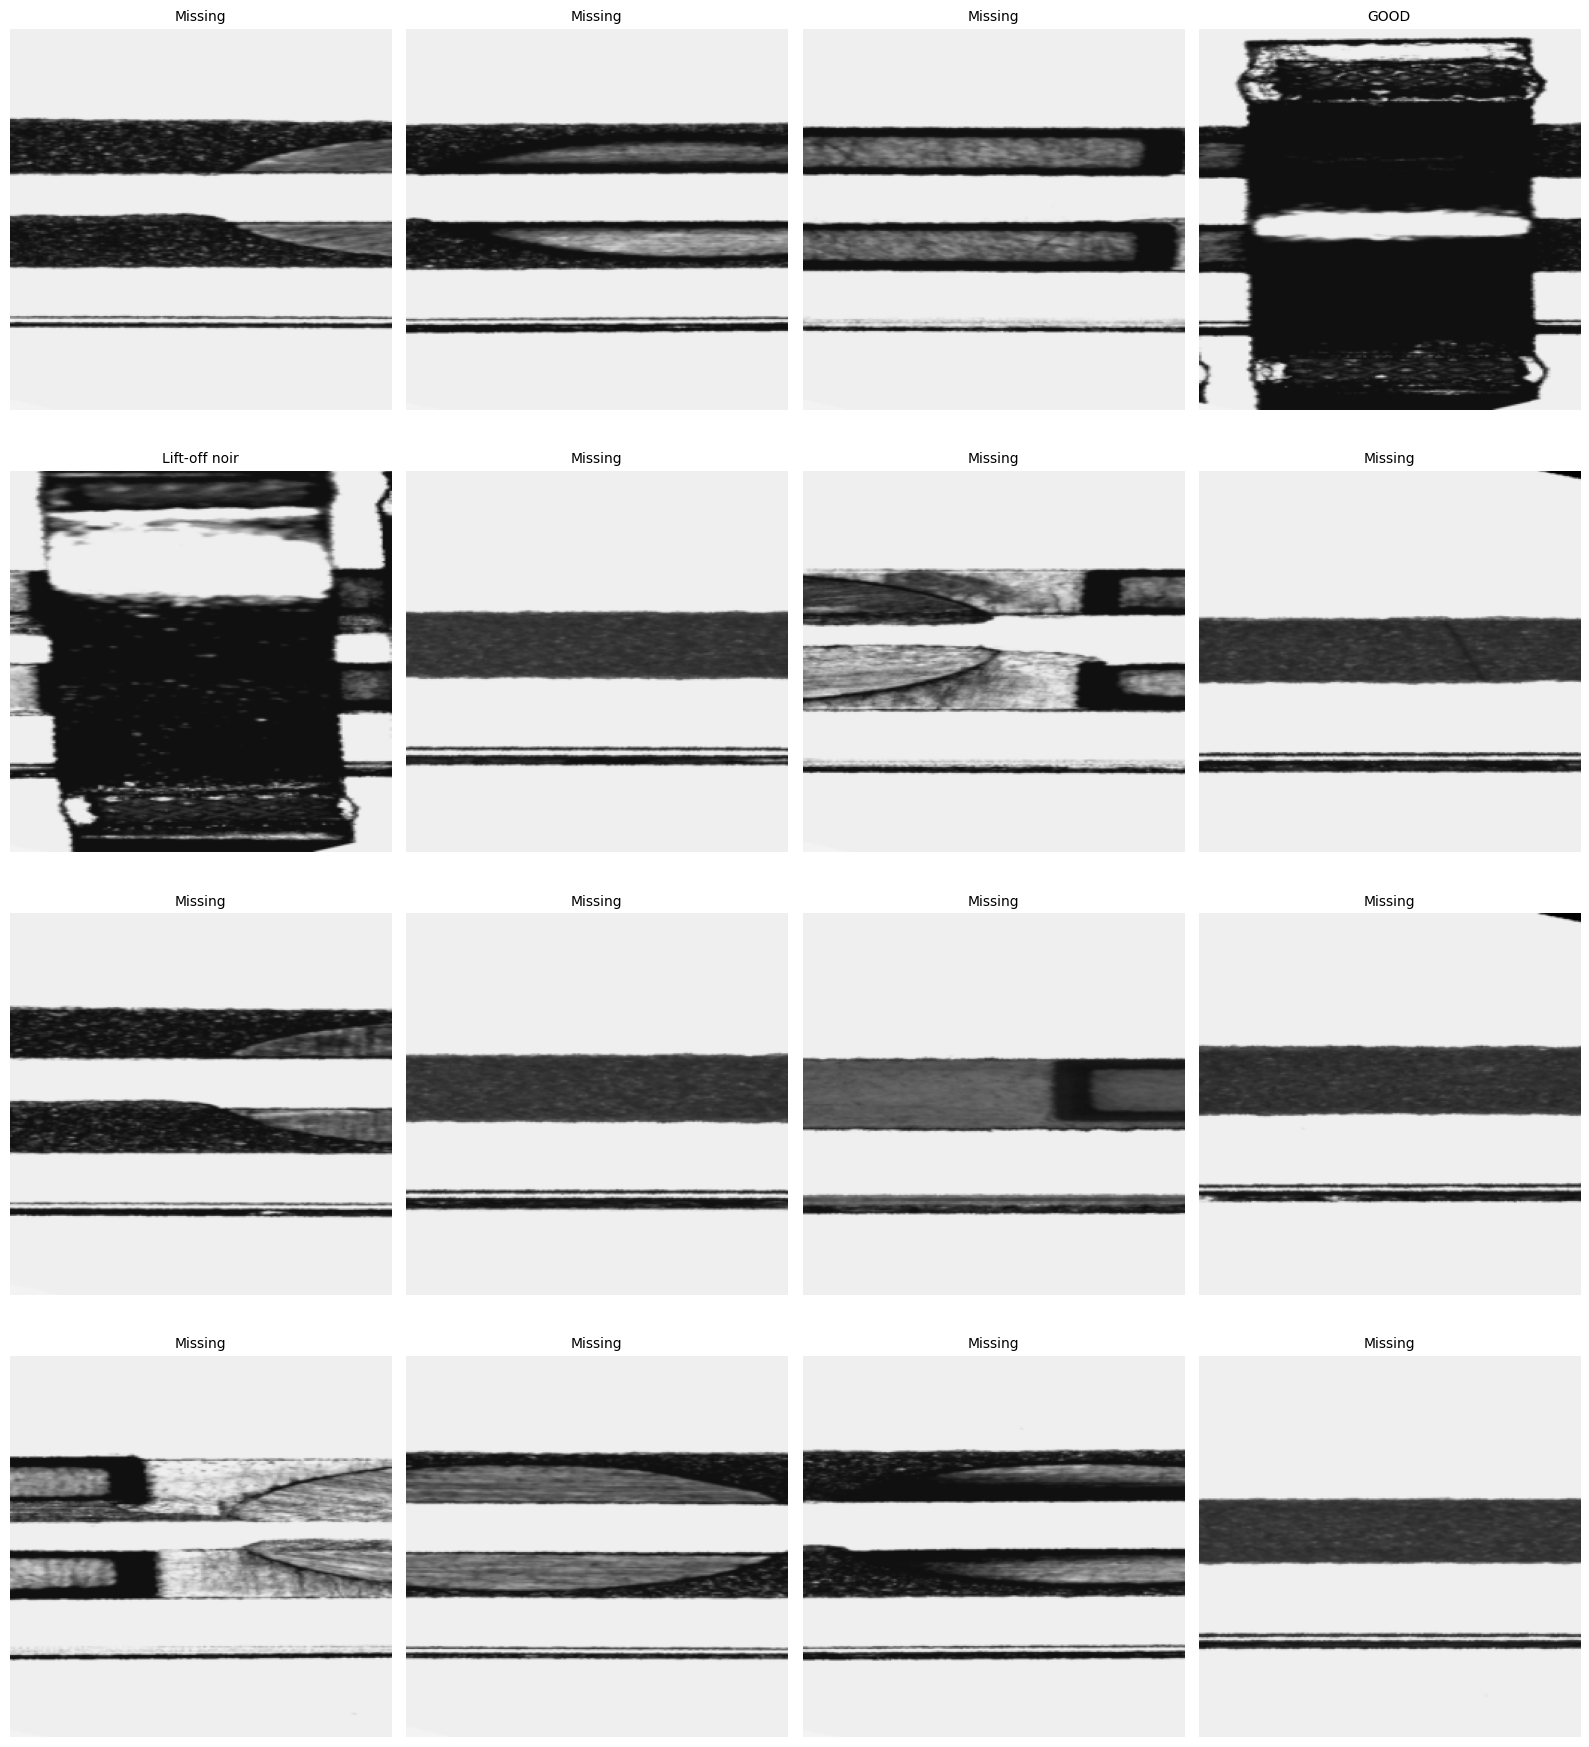

In [8]:
def show_image_grid(dataloader, label_map, num_images=16, grid_size=(4, 4)):
    images, labels = next(iter(dataloader))  # Get a batch of images and labels
    num_images = min(num_images, len(images))  # Limit to available images

    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(16, 18))
    axes = axes.flatten()  # Flatten to iterate easily
    for i in range(num_images):
        img = FTV.to_pil_image(images[i])  # Convert tensor to PIL image
        label = labels[i].item()  # Get label as int
        
        axes[i].imshow(img)
        axes[i].set_title(label_map[label], fontsize=10)  # Use label_map to get class name
        axes[i].axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()

show_image_grid(dataset_loader, map_idx_label)

In [9]:
label_counts = labeled_dataset.data["Label"].value_counts()

for label_name, count in label_counts.items():
    print(f"Class {label_name}: {count} images")

Class Missing: 6472 images
Class GOOD: 1235 images
Class Lift-off blanc: 270 images
Class Short circuit MOS: 126 images
Class Lift-off noir: 104 images
Class Boucle plate: 71 images


# General notes

- Dataset  : (inbalanced classes) (oversampling, undersampling, class weights

- Use IsolationForest maybe for detecting the drift class dans une approche non supervisée

# Data Augmentation

In [10]:
augment_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomRotation(degrees=15),  # Rotate randomly within ±15°
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color variations
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Random distortions
    transforms.ToTensor(),  # Convert to tensor
])

augmented_dataset = cl.CustomImageDataset(true_labels, labeled_pictures, map_label_idx, transform=augment_transform)
aug_data_loader = DataLoader(augmented_dataset, batch_size=256, shuffle=True)

In [11]:
print(f"Dataset contains {len(augmented_dataset)} images.")

image, label = augmented_dataset[0]
print(f"Image shape: {image.shape}, Label: {label}")

Dataset contains 8278 images.
Image shape: torch.Size([3, 256, 256]), Label: 4


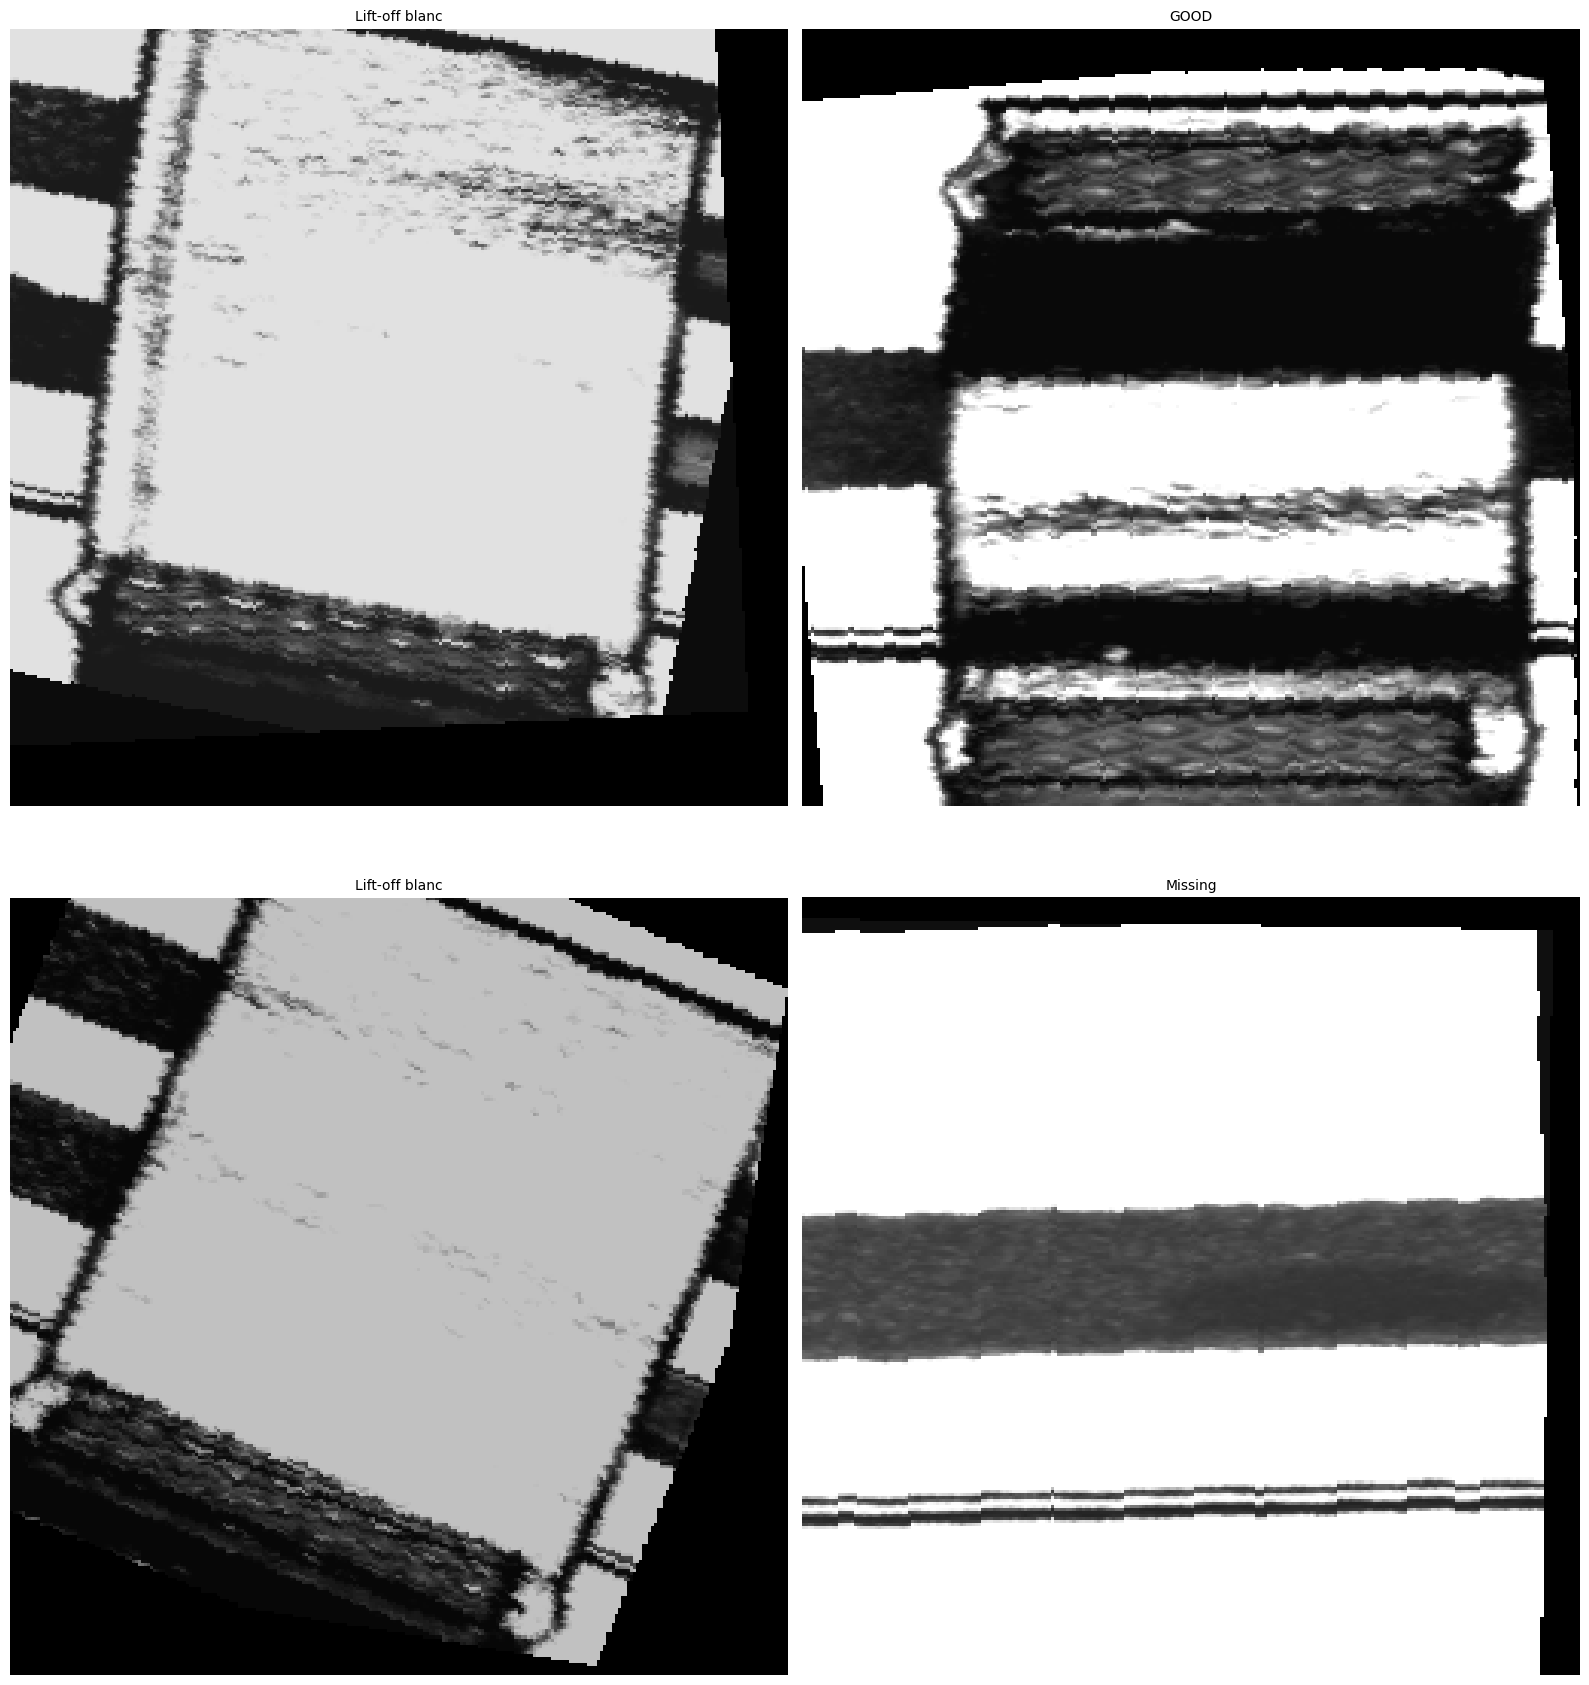

In [12]:
show_image_grid(aug_data_loader, map_idx_label, num_images=4, grid_size=(2, 2))

In [13]:
# Define split sizes (e.g., 80% train, 20% val)
train_size = int(0.8 * len(augmented_dataset))
val_size = len(augmented_dataset) - train_size

# Split dataset
train_subset, val_subset = random_split(augmented_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=256, shuffle=False)

print(f"Train samples: {len(train_subset)}, Validation samples: {len(val_subset)}")


Train samples: 6622, Validation samples: 1656


# First Try : Fine tune a ResNet

In [14]:
model = resnet18(pretrained=True)

# Modify the final fully connected layer to match your number of classes
num_ftrs = model.fc.in_features 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\mouad\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(map_label_idx))

# we will try to finetune the last layer and the classification head
for param in model.fc.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

In [18]:
class_counts = torch.tensor(label_counts.values, dtype=torch.float)
class_counts

tensor([6472., 1235.,  270.,  126.,  104.,   71.])

- Une manière de lutter contre l'impact des données déséquilibrées consiste à modifier les fonctions de loss de telle manière que les données mal prédites de la classe minoritaire soient fortement pénalisées. La fonction de loss est pondérée pour chaque $x_i, y_i$ par un poids $w_i$. Pour la classification binaire la fonction de loss peut être définie comme ci-dessous:

    $L(\theta) = - \sum_{j=0}^{1} w_j \sum_{y_i=j} f(P(y_i|x_i, \theta))$

    Dans scikit-learn, les poids d'équilibrage sont calculés suivant cette formule:

    $w_j = \frac{N}{C * |y_i = j|_{i=1 \dots N}}$

In [19]:
# we compute the classical way of class weights, meaning we will give more important to underepresenated class
total_samples = class_counts.sum()
num_classes = len(class_counts)

class_weights = total_samples / (num_classes * class_counts)
class_weights

tensor([ 0.2132,  1.1171,  5.1099, 10.9497, 13.2660, 19.4319])

In [ ]:
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4) 
# we only update the parametrs that are unfreezed

In [22]:
num_epochs = 10
train_losses = []
val_losses = []
patience = 5  # Number of epochs to wait before stopping if no improvement
best_val_loss = float("inf")  # Initialize with a very high value
early_stop_counter = 0  # Tracks epochs without improvement

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images) 
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()
        train_loop.set_postfix(loss=loss.item()) # update the progress bar


    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # we fetch the max output
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            val_loop.set_postfix(loss=loss.item(), accuracy=(correct / total * 100))

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = correct / total * 100

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset counter if validation loss improves
        torch.save(model.state_dict(), "models\early_stopping_model.pth")  # Save the best model
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("Early stopping triggered! Stopping training.")
        break  # Stop training


print("Training complete!")

KeyboardInterrupt: 

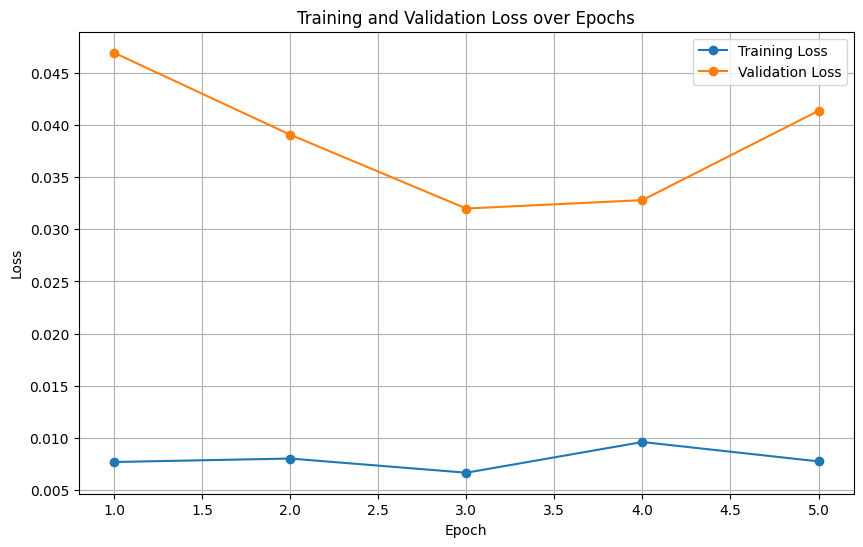

In [26]:
# visualize train and val erros, see also confusion matrix, ou peut être courbe ROC
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
all_labels = []
all_preds = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)


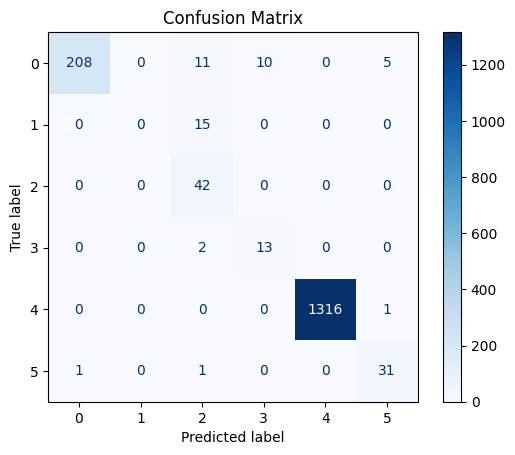

In [32]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5])  # Update with your class labels if needed
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Training a ViT model (finetuning)

In [ ]:
import timm

In [ ]:
model_vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)

In [ ]:
num_epochs = 10
train_losses = []
val_losses = []
patience = 5  # Number of epochs to wait before stopping if no improvement
best_val_loss = float("inf")  # Initialize with a very high value
early_stop_counter = 0  # Tracks epochs without improvement

for epoch in range(num_epochs):
    model_vit.train()
    running_loss = 0.0

    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
    for images, labels in train_loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_vit(images) 
        loss = criterion(outputs, labels) 
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item()
        train_loop.set_postfix(loss=loss.item()) # update the progress bar


    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model_vit.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model_vit(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # we fetch the max output
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            val_loop.set_postfix(loss=loss.item(), accuracy=(correct / total * 100))

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    accuracy = correct / total * 100

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0  # Reset counter if validation loss improves
        torch.save(model_vit.state_dict(), "models\early_stopping_model_vit.pth")  # Save the best model
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")

    if early_stop_counter >= patience:
        print("Early stopping triggered! Stopping training.")
        break  # Stop training


print("Training complete!")

In [ ]:
# visualize train and val erros, see also confusion matrix, ou peut être courbe ROC
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Load the test set and evaluate

In [12]:
# preprocess also the test dataset
transform = transforms.Compose([
                                transforms.Resize((256, 256)),  # Redimensionner les images
                                transforms.ToTensor(),            # Convertir en tenseur
                                ])
test_path= 'input_test_1a4aqAg\input_test'
test_dataset = c.CustomDataset(test_path, transform)
test_dataloader = DataLoader(test_dataset, batch_size=256, pin_memory=True)

### Subsection : Try the Isolation Forest to distinguish between the 'known' parts (those of training) and unseen ones (the drift class)

In [29]:
import torchvision.models as models

class FeatureExtractor(nn.Module):
    def __init__(self, num_classes=6):
        super(FeatureExtractor, self).__init__()
        # Load a pretrained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        
        # Remove the final fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        
        # Add a new fully connected layer for classification (optional, if needed)
        self.fc = nn.Linear(2048, num_classes)
    
    def forward(self, x, return_features=False):
        # Extract features
        features = self.features(x)
        features = torch.flatten(features, 1)  # Flatten the features
        
        if return_features:
            return features  # Return features only
        else:
            # Return classification output
            output = self.fc(features)
            return output

# Instantiate the model
extractor_model = FeatureExtractor(num_classes=6)

In [30]:
extractor_model

FeatureExtractor(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [31]:
# Load the saved weights
weights_path = f'model_weights_{iteration}.pth'
extractor_model.load_state_dict(torch.load(weights_path))

C:\Users\mouad\AppData\Local\Temp\ipykernel_38596\894777782.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  extractor_model.load_state_dict(torch.load(weights_path))


RuntimeError: Error(s) in loading state_dict for FeatureExtractor:
	Missing key(s) in state_dict: "resnet.0.weight", "resnet.1.weight", "resnet.1.bias", "resnet.1.running_mean", "resnet.1.running_var", "resnet.4.0.conv1.weight", "resnet.4.0.bn1.weight", "resnet.4.0.bn1.bias", "resnet.4.0.bn1.running_mean", "resnet.4.0.bn1.running_var", "resnet.4.0.conv2.weight", "resnet.4.0.bn2.weight", "resnet.4.0.bn2.bias", "resnet.4.0.bn2.running_mean", "resnet.4.0.bn2.running_var", "resnet.4.1.conv1.weight", "resnet.4.1.bn1.weight", "resnet.4.1.bn1.bias", "resnet.4.1.bn1.running_mean", "resnet.4.1.bn1.running_var", "resnet.4.1.conv2.weight", "resnet.4.1.bn2.weight", "resnet.4.1.bn2.bias", "resnet.4.1.bn2.running_mean", "resnet.4.1.bn2.running_var", "resnet.5.0.conv1.weight", "resnet.5.0.bn1.weight", "resnet.5.0.bn1.bias", "resnet.5.0.bn1.running_mean", "resnet.5.0.bn1.running_var", "resnet.5.0.conv2.weight", "resnet.5.0.bn2.weight", "resnet.5.0.bn2.bias", "resnet.5.0.bn2.running_mean", "resnet.5.0.bn2.running_var", "resnet.5.0.downsample.0.weight", "resnet.5.0.downsample.1.weight", "resnet.5.0.downsample.1.bias", "resnet.5.0.downsample.1.running_mean", "resnet.5.0.downsample.1.running_var", "resnet.5.1.conv1.weight", "resnet.5.1.bn1.weight", "resnet.5.1.bn1.bias", "resnet.5.1.bn1.running_mean", "resnet.5.1.bn1.running_var", "resnet.5.1.conv2.weight", "resnet.5.1.bn2.weight", "resnet.5.1.bn2.bias", "resnet.5.1.bn2.running_mean", "resnet.5.1.bn2.running_var", "resnet.6.0.conv1.weight", "resnet.6.0.bn1.weight", "resnet.6.0.bn1.bias", "resnet.6.0.bn1.running_mean", "resnet.6.0.bn1.running_var", "resnet.6.0.conv2.weight", "resnet.6.0.bn2.weight", "resnet.6.0.bn2.bias", "resnet.6.0.bn2.running_mean", "resnet.6.0.bn2.running_var", "resnet.6.0.downsample.0.weight", "resnet.6.0.downsample.1.weight", "resnet.6.0.downsample.1.bias", "resnet.6.0.downsample.1.running_mean", "resnet.6.0.downsample.1.running_var", "resnet.6.1.conv1.weight", "resnet.6.1.bn1.weight", "resnet.6.1.bn1.bias", "resnet.6.1.bn1.running_mean", "resnet.6.1.bn1.running_var", "resnet.6.1.conv2.weight", "resnet.6.1.bn2.weight", "resnet.6.1.bn2.bias", "resnet.6.1.bn2.running_mean", "resnet.6.1.bn2.running_var", "resnet.7.0.conv1.weight", "resnet.7.0.bn1.weight", "resnet.7.0.bn1.bias", "resnet.7.0.bn1.running_mean", "resnet.7.0.bn1.running_var", "resnet.7.0.conv2.weight", "resnet.7.0.bn2.weight", "resnet.7.0.bn2.bias", "resnet.7.0.bn2.running_mean", "resnet.7.0.bn2.running_var", "resnet.7.0.downsample.0.weight", "resnet.7.0.downsample.1.weight", "resnet.7.0.downsample.1.bias", "resnet.7.0.downsample.1.running_mean", "resnet.7.0.downsample.1.running_var", "resnet.7.1.conv1.weight", "resnet.7.1.bn1.weight", "resnet.7.1.bn1.bias", "resnet.7.1.bn1.running_mean", "resnet.7.1.bn1.running_var", "resnet.7.1.conv2.weight", "resnet.7.1.bn2.weight", "resnet.7.1.bn2.bias", "resnet.7.1.bn2.running_mean", "resnet.7.1.bn2.running_var". 
	Unexpected key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.conv1.weight", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.conv2.weight", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.conv1.weight", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.conv2.weight", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer2.0.conv1.weight", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.conv2.weight", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.0.downsample.0.weight", "layer2.0.downsample.1.weight", "layer2.0.downsample.1.bias", "layer2.0.downsample.1.running_mean", "layer2.0.downsample.1.running_var", "layer2.0.downsample.1.num_batches_tracked", "layer2.1.conv1.weight", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.conv2.weight", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer3.0.conv1.weight", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.conv2.weight", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.0.downsample.0.weight", "layer3.0.downsample.1.weight", "layer3.0.downsample.1.bias", "layer3.0.downsample.1.running_mean", "layer3.0.downsample.1.running_var", "layer3.0.downsample.1.num_batches_tracked", "layer3.1.conv1.weight", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.conv2.weight", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer4.0.conv1.weight", "layer4.0.bn1.weight", "layer4.0.bn1.bias", "layer4.0.bn1.running_mean", "layer4.0.bn1.running_var", "layer4.0.bn1.num_batches_tracked", "layer4.0.conv2.weight", "layer4.0.bn2.weight", "layer4.0.bn2.bias", "layer4.0.bn2.running_mean", "layer4.0.bn2.running_var", "layer4.0.bn2.num_batches_tracked", "layer4.0.downsample.0.weight", "layer4.0.downsample.1.weight", "layer4.0.downsample.1.bias", "layer4.0.downsample.1.running_mean", "layer4.0.downsample.1.running_var", "layer4.0.downsample.1.num_batches_tracked", "layer4.1.conv1.weight", "layer4.1.bn1.weight", "layer4.1.bn1.bias", "layer4.1.bn1.running_mean", "layer4.1.bn1.running_var", "layer4.1.bn1.num_batches_tracked", "layer4.1.conv2.weight", "layer4.1.bn2.weight", "layer4.1.bn2.bias", "layer4.1.bn2.running_mean", "layer4.1.bn2.running_var", "layer4.1.bn2.num_batches_tracked". 
	size mismatch for fc.weight: copying a param with shape torch.Size([6, 512]) from checkpoint, the shape in current model is torch.Size([6, 2048]).

# Evaluate direcly using the simple thresholding rule

In [21]:
model.load_state_dict(torch.load(f"model_weights_{iteration}.pth", weights_only=True))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
model.eval()

all_predics = [] # contains tuples (filename, array of logits of length 6)
with torch.no_grad():
    for filenames, images in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        logits = outputs.cpu().numpy()
        all_predics.extend(zip(filenames, logits))

In [35]:
# to do, convert them to proba using softmax and then define a manual threshold for if never
# seen then new class, else then take the max index

results = []
threshold = 0.5
for image_path, logits_6 in all_predics:
    logits_7 = np.append(logits_6, 0)# Adding the dummy logit for 7th class
    logits_tensor = torch.tensor(logits_7)
    probabilities = F.softmax(logits_tensor, dim=0)
    # Check if the maximum probability is below the threshold for all known classes (first 6)
    max_prob = torch.max(probabilities[:6]).item()

    if max_prob < threshold:
        predicted_class = 6  # New class (class 7)
    else:
        predicted_class = torch.argmax(probabilities).item()
    results.append({
        'filename': image_path,
        'softmax': probabilities.numpy(),  # Convert tensor to numpy array for storage
        'Label': predicted_class,
    })

In [36]:
test_result_df = pd.DataFrame(results, columns=['filename', 'softmax', 'Label'])

In [37]:
test_result_df.head()

,filename,softmax,Label
0,003943cefade46399db0adf9e4a1a4f14ba55033770b92...,"[1.136765709576315e-06, 0.0013920464811900334,...",2
1,004acab8e86eced72f6aa676c83f58620365b249affa2b...,"[4.686716712521422e-06, 0.00018967863229871226...",2
2,0097035d8b03da345aab4afd2b95ff4c30c1d1f0d22cd2...,"[8.805594769393245e-08, 0.0004676776961744247,...",2
3,00c7e00fc6db3f9b53130689de8e895107cb501aebf499...,"[0.00011941331112536424, 0.04970682571764218, ...",2
4,0126d9e617c49a7829051ddd289cb4fef41e08f7f01ac9...,"[1.4762510212215211e-05, 0.0004193387257698758...",2


In [39]:
test_result_df['Label'].value_counts()

Label
2    970
3     78
6      7
Name: count, dtype: int64

In [38]:
iteration = 2
test_result_df[['filename', 'Label']].to_csv(f'Y_test_submission_{iteration}.csv', index=True)